In [42]:
import requests
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import *
from functions import *
import folium

In [2]:
###checking distance function

In [3]:
# São Paulo -> Rio de Janeiro
dist_km = osrm_distance(-23.5505, -46.6333, -22.9068, -43.1729)

print(f"Driving distance: {dist_km:.2f} km")
#print(f"Estimated duration: {duration_min:.1f} min")

Driving distance: 433.62 km


### 1. Computing distance matrix

In [4]:
###loading dfs
info_dc = pd.read_csv("data/distribution_center_dataframe.csv")
info_stores = pd.read_csv("data/stores_dataframe.csv")

In [5]:
info_dc

,distribution_center,latitude,longitude,supply
0,dca,-8.971053,-55.773196,1510
1,dcb,-20.257081,-50.834509,1847
2,dcc,-11.273721,-51.490627,1040
3,dcd,-10.854486,-46.383194,1947
4,dce,-11.802726,-50.969810,1263
5,dcf,-10.802853,-52.548780,1533
6,dcg,-8.289540,-45.265429,1539
7,dch,-7.077118,-56.739872,1420
8,dci,-5.911711,-56.545805,1352
9,dcj,-12.417353,-49.881595,1178


In [6]:
### extracting lat-lon coordinates
dc_coords = list(info_dc[["latitude", "longitude"]].itertuples(index=False, name=None))
stores_coords = list(info_stores[["latitude", "longitude"]].itertuples(index=False, name=None))

In [7]:
###computing distance matrix
n, m = len(dc_coords), len(stores_coords)
dist_mat = np.zeros((n, m))
dist_mat = osrm_table(dc_coords, stores_coords)
print(dist_mat.shape)   # (n_cds, n_lojas)
print(dist_mat[:3, :3]) # preview

(10, 20)
[[2012.618  2008.4135 1571.3873]
 [1895.4803 1889.5261  405.0007]
 [1338.8951 1332.941   932.3173]]


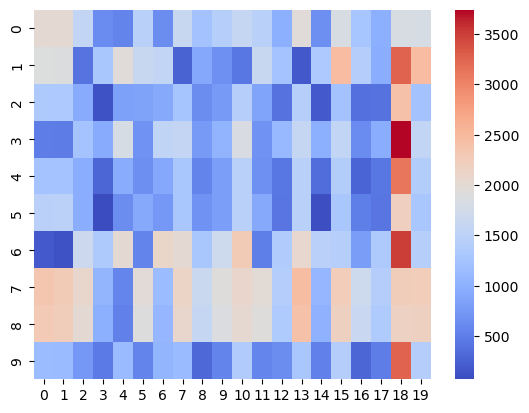

In [8]:
sns.heatmap(dist_mat, cmap='coolwarm')
plt.show()

### 2. Creating variables

In [9]:
supply = {}
for i in range(n):
    supply[info_dc.iloc[i,0]] = info_dc.iloc[i,3]  # Example: each CD has a supply of 1000 units    

In [10]:
demand = {}
for i in range(m):
    demand[info_stores.iloc[i,0]] = info_stores.iloc[i,3]  # Example: each store has a demand of 100 units

In [11]:
warehouses = info_dc["distribution_center"].tolist()
stores = info_stores["store"].tolist()

In [12]:
warehouses

['dca', 'dcb', 'dcc', 'dcd', 'dce', 'dcf', 'dcg', 'dch', 'dci', 'dcj']

In [13]:
# The cost data is made into a dictionary
costs_dict = makeDict([warehouses, stores], dist_mat, 0)

In [14]:
# Creates the 'prob' variable to contain the problem data
prob = LpProblem("transport_distribution_problem", LpMinimize)

In [15]:
# Creates a list of tuples containing all the possible routes for transport
Routes = [(w, s) for w in warehouses for s in stores]

# A dictionary called 'Vars' is created to contain the referenced variables(the routes)
vars = LpVariable.dicts("Route", (warehouses, stores), 0, None, LpInteger)

# The objective function is added to 'prob' first
prob += (
    lpSum([vars[w][s] * costs_dict[w][s] for (w, s) in Routes]),
    "Sum_of_Transporting_Costs",
)

In [16]:
# The supply maximum constraints are added to prob for each supply node (warehouse)
for w in warehouses:
    prob += (
        lpSum([vars[w][s] for s in stores]) <= supply[w],
        f"Sum_of_Products_out_of_Warehouse_{w}",
    )

In [17]:
# The demand minimum constraints are added to prob for each demand node (bar)
for s in stores:
    prob += (
        lpSum([vars[w][s] for w in warehouses]) >= demand[s],
        f"Sum_of_Products_into_Bar{s}",
    )

In [18]:
print("Number of variables:", len(prob.variables()))
print("Number of constraints:", len(prob.constraints))

Number of variables: 200
Number of constraints: 30


In [19]:
listSolvers(onlyAvailable=True)

['PULP_CBC_CMD', 'COIN_CMD', 'HiGHS_CMD']

In [20]:
# The problem is solved using HiGHS Solver
prob.solve()

1

In [21]:
# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

Status: Optimal


### 3. Plotting created routes

In [22]:
###checking the routes
for w in warehouses:
    for s in stores:
        if vars[w][s].varValue > 0:
            print(f"From {w} to {s}: {vars[w][s].varValue}")

From dca to storeg: 489.0
From dca to stores: 488.0
From dcb to storec: 397.0
From dcb to storeh: 338.0
From dcb to storek: 350.0
From dcb to storen: 440.0
From dcc to storem: 417.0
From dcc to storep: 318.0
From dcc to storet: 305.0
From dce to storeq: 313.0
From dcf to stored: 477.0
From dcf to storem: 21.0
From dcf to storeo: 442.0
From dcf to storer: 431.0
From dcg to storea: 322.0
From dcg to storeb: 372.0
From dcg to storef: 406.0
From dcg to storel: 312.0
From dci to storee: 359.0
From dcj to storei: 440.0
From dcj to storej: 481.0


In [ ]:
###checking the used warehouses with positive routes
used_war = {}
for w in warehouses:
    used_stores = []
    for s in stores:
        if vars[w][s].varValue > 0:
            used_stores.append(s)
            used_war[w] = used_stores

In [108]:
def routes(ori):
    #collecting origin lat lon coordinates
    idx = info_dc.index[info_dc['distribution_center']==ori]
    collat = info_dc.columns.get_loc('latitude')
    collon = info_dc.columns.get_loc('longitude')
    lat = float(info_dc.iloc[idx,collat])
    lon = float(info_dc.iloc[idx,collon])
    origin = [lat,lon]
    map_dc = folium.Map(location=origin)
    folium.Marker(location=origin, popup=f"Distribution center {ori}.").add_to(map_dc)

    #creating list of destinations
    destinations = []
    for store in used_war[ori]:
        store1 = []
        idx = info_stores.index[info_stores['store']==store]
        collat = info_stores.columns.get_loc('latitude')
        collon = info_stores.columns.get_loc('longitude')
        store1.append(float(info_stores.iloc[idx,collat]))
        store1.append(float(info_stores.iloc[idx,collon]))
        destinations.append(store1)

    #creating list of routes
    routes_ori = []
    for dest in destinations:
        route1 = []
        route1.append(origin)
        route1.append(dest)
        routes_ori.append(route1)

    # Add red markers for stores
    for i in range(len(routes_ori)):
        folium.Marker(location=routes_ori[i][1], icon=folium.Icon(color="red")).add_to(map_dc)
    # Add the PolyLine to represent the route
    for i in range(len(routes_ori)):
        folium.PolyLine(routes_ori[i], color="blue", weight=5, opacity=0.7).add_to(map_dc)
    map_dc.save(f"maps/{ori}_routes.html")
        

In [110]:
routes('dcc')

C:\Users\user\AppData\Local\Temp\ipykernel_5364\632712655.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat = float(info_dc.iloc[idx,collat])
C:\Users\user\AppData\Local\Temp\ipykernel_5364\632712655.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lon = float(info_dc.iloc[idx,collon])
C:\Users\user\AppData\Local\Temp\ipykernel_5364\632712655.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  store1.append(float(info_stores.iloc[idx,collat]))
C:\Users\user\AppData\Local\Temp\ipykernel_5364\632712655.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  store1.append(float(info_stores.ilo

In [156]:
def all_routes():
    #creating the first marker to the map
    idx = info_dc.index[info_dc['distribution_center']=='dca']
    collat = info_dc.columns.get_loc('latitude')
    collon = info_dc.columns.get_loc('longitude')
    lat = float(info_dc.iloc[idx,collat])
    lon = float(info_dc.iloc[idx,collon])
    origin = [lat,lon]
    map = folium.Map(location=origin)

    ##adding blue markers to distribution centers
    for dc in used_war:
        idx = info_dc.index[info_dc['distribution_center']==dc]
        collat = info_dc.columns.get_loc('latitude')
        collon = info_dc.columns.get_loc('longitude')
        lat = float(info_dc.iloc[idx,collat])
        lon = float(info_dc.iloc[idx,collon])
        point = [lat,lon]
        folium.Marker(location=point, icon=folium.Icon(color="blue"), popup=f"Distribution center {dc}.").add_to(map)
    
    ##adding red markers to stores
    for store in used_stores:
        idx = info_stores.index[info_stores['store']==store]
        collat = info_stores.columns.get_loc('latitude')
        collon = info_stores.columns.get_loc('longitude')
        lat = float(info_stores.iloc[idx,collat])
        lon = float(info_stores.iloc[idx,collon])
        point = [lat,lon]
        folium.Marker(location=point, icon=folium.Icon(color="red"), popup=f"Store {store}.").add_to(map)

    ##adding routes
    for ori in used_war.keys():
        idx = info_dc.index[info_dc['distribution_center']==ori]
        collat = info_dc.columns.get_loc('latitude')
        collon = info_dc.columns.get_loc('longitude')
        lat = float(info_dc.iloc[idx,collat])
        lon = float(info_dc.iloc[idx,collon])
        origin = [lat,lon] 
    #creating list of destinations
        destinations = []
        for store in used_war[ori]:
            store1 = []
            idx = info_stores.index[info_stores['store']==store]
            collat = info_stores.columns.get_loc('latitude')
            collon = info_stores.columns.get_loc('longitude')
            store1.append(float(info_stores.iloc[idx,collat]))
            store1.append(float(info_stores.iloc[idx,collon]))
            destinations.append(store1)

        #creating list of routes
        routes_ori = []
        for dest in destinations:
            route1 = []
            route1.append(origin)
            route1.append(dest)
            routes_ori.append(route1)


        # Add the PolyLine to represent the route
        for i in range(len(routes_ori)):
            folium.PolyLine(routes_ori[i], color="blue", weight=5, opacity=0.7).add_to(map)
        map.save(f"maps/all_routes.html")



    

In [158]:
used_stores = []
for war in used_war:
    for i in range(len(used_war[war])):
        used_stores.append(used_war[war][i])      


In [157]:
all_routes()

C:\Users\user\AppData\Local\Temp\ipykernel_5364\983325751.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat = float(info_dc.iloc[idx,collat])
C:\Users\user\AppData\Local\Temp\ipykernel_5364\983325751.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lon = float(info_dc.iloc[idx,collon])
C:\Users\user\AppData\Local\Temp\ipykernel_5364\983325751.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat = float(info_dc.iloc[idx,collat])
C:\Users\user\AppData\Local\Temp\ipykernel_5364\983325751.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lon = float(info_dc.iloc[idx,collon])
C:\Users\u